# Load as a Tensorflow Dataset

This notebook requires `librosa`, `matplotlib` and `tensorflow_io` beyond `pmqd`. Uncomment below to install the requirements.

In [1]:
#!pip install git+https://github.com/Peltarion/pmqd#egg=pmqd
#!pip install librosa matplotlib tensorflow_io

----------

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pmqd.tfds
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_io as tfio
from IPython.display import Audio
from librosa.display import specshow

First load the dataset and extract metadata like sample_rate and the function for converting degradation type codes to their corresponding name.

In [3]:
dataset, info = tfds.load("PMQD", split="test", with_info=True)
sample_rate = info.features["audio"].sample_rate
decode_degradation = info.features["degradation_type"].int2str

Now we can listen to a few random samples from the dataset.

In [4]:
for example in dataset.shuffle(128).take(3):
    audio, rating = example["audio"], example["rating"]
    
    degradation_type = decode_degradation(example["degradation_type"])
    degradation_intensity = example["degradation_intensity"]

    print(f"Degradation {degradation_type}({degradation_intensity:.2f}%) with rating {rating}: ")
    display(Audio(audio.numpy().T, rate=sample_rate))

Degradation original(0.00%) with rating 4.0: 


Degradation noise(82.58%) with rating 1.0: 


Degradation original(0.00%) with rating 4.0: 


To produce the results in our paper [Perceiving Music Quality with GANs](https://arxiv.org/abs/2006.06287), we used a preprocessing pipeline equivalent to the follwing. It creates log mel spectrogram from the first channel with the shape 256 x 256 (mel frequency x time).

In [5]:
reduced_sample_rate = 16000
window_size = 2048
hop_size = 256
num_mels = 256

In [6]:
def preprocess(item):
    audio, rating = item["audio"], item["rating"]
    
    # Select the first channel and resample to 16kHz
    channel = audio[..., 0]
    resampled = tfio.audio.resample(
        channel,
        rate_in=sample_rate,
        rate_out=reduced_sample_rate
    )

    # Produce log mel-spectrograms.
    # `tfio.experimental.audio.spectrogram` would be another, less flexible option
    spectrogram = tf.abs(tf.signal.stft(
        resampled,
        frame_length=window_size,
        fft_length=window_size,
        frame_step=hop_size,
        window_fn=tf.signal.hann_window,
        pad_end=False,
    ))
    
    # Mel scale the frequency axis
    mel_spectrogram = tfio.experimental.audio.melscale(
        spectrogram,
        rate=reduced_sample_rate,
        mels=num_mels,
        fmin=0,
        fmax=reduced_sample_rate / 2
    )
    # Switch from [time_steps, frequencies] to [frequencies, time_steps]
    mel_spectrogram = tf.linalg.matrix_transpose(mel_spectrogram)

    # Log scale intensities, another option would be the dB transform
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-3)    
    return log_mel_spectrogram, rating


mel_dataset = dataset.map(preprocess).batch(32)

Finally, to visualize what this achieves, we plot the first mel spectrogram of each batch. Notice how we transpose and flip the image to have the time axis along `x` and the frequency axis along `y`. This becomes easier with [librosa.display.specshow](https://librosa.org/doc/main/generated/librosa.display.specshow.html) which also sets the axis with the desired units.

/usr/local/anaconda3/envs/pmqd/lib/python3.6/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/usr/local/anaconda3/envs/pmqd/lib/python3.6/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


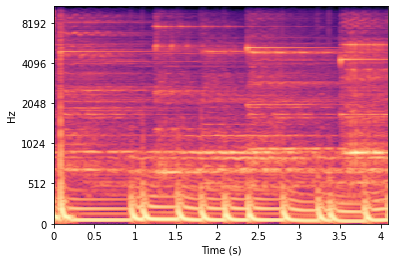

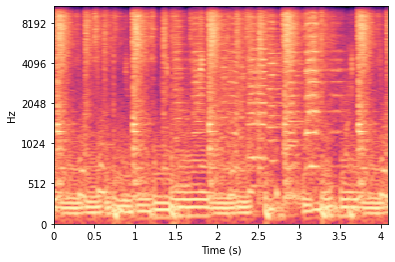

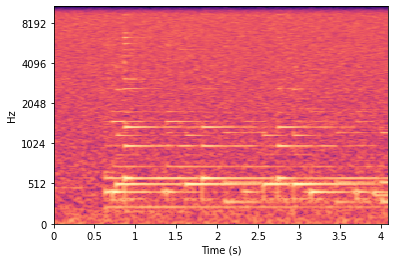

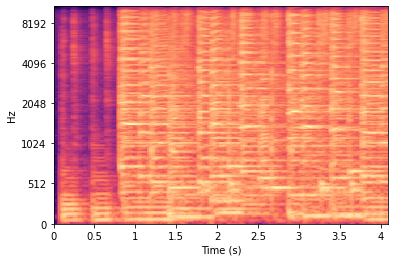

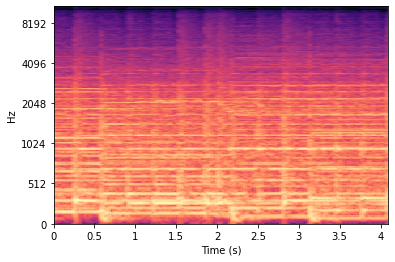

In [7]:
for mel_spectrograms, rating in mel_dataset.take(5):
    specshow(
        mel_spectrograms[0].numpy(),
        sr=reduced_sample_rate,
        hop_length=hop_size,
        x_axis="s",
        y_axis="mel"
    )
    plt.show()